# Main model

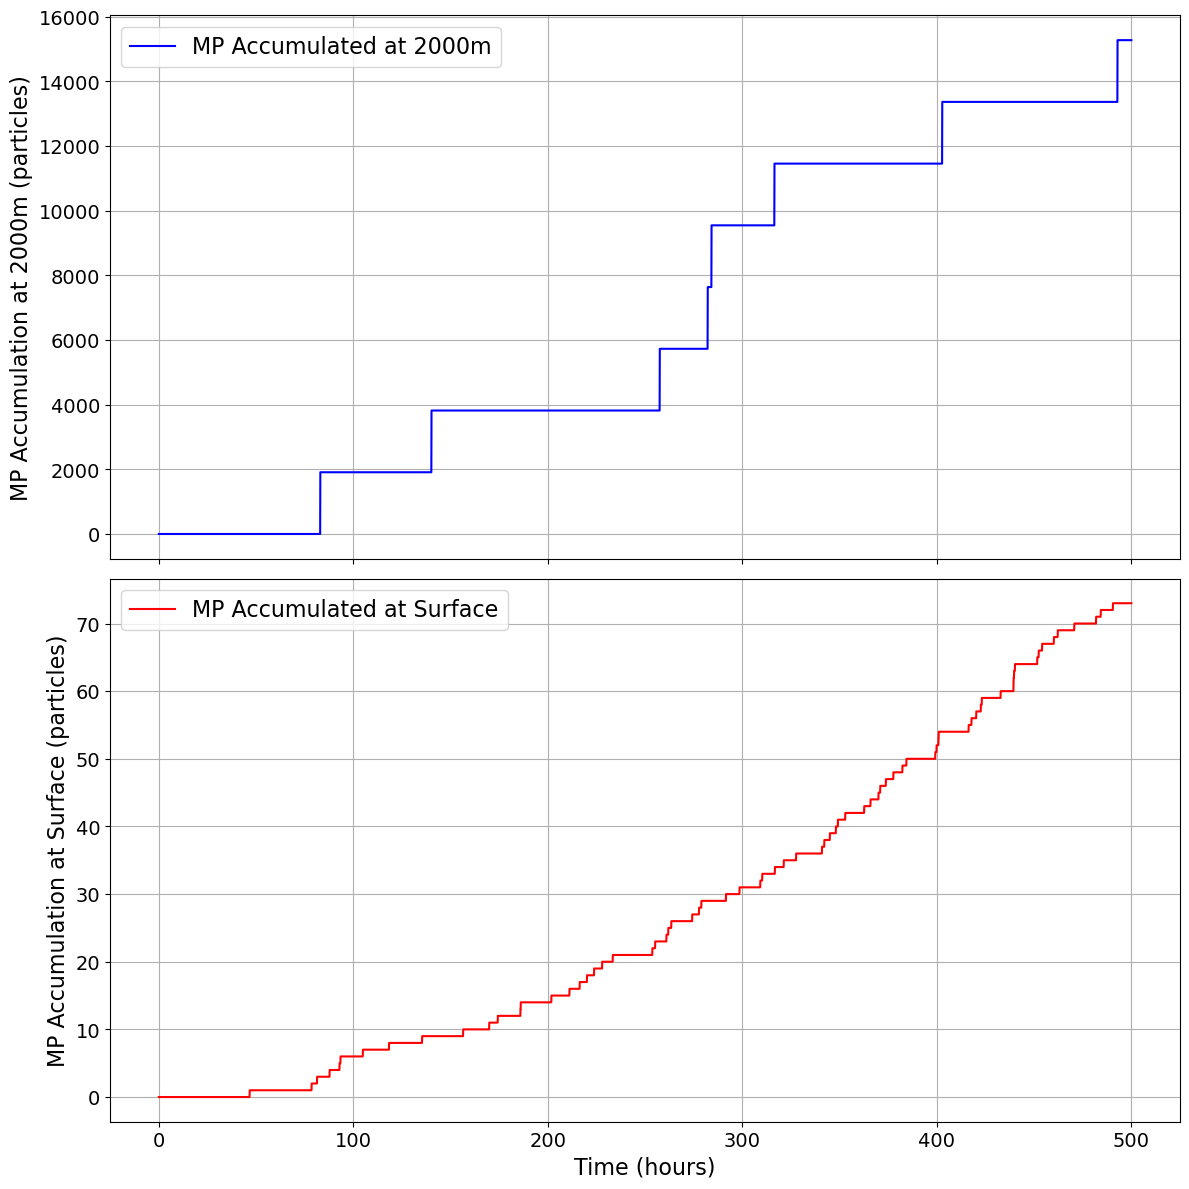

Avg sinking velocity: 466.5155472737943 m/day, Avg rising velocity: 0.747469777086894 m/hour
[41.5 35.5 29.5 32.5 25.5 19.5 33.5 12.5 34.5 47.5]


In [1]:
#%% more efficient main code
import numpy as np
import matplotlib.pyplot as plt
from onekrill_onecolumn import (
    calc_clearance_rate,
    calc_krill_mp_consumption,
    calc_mp_fp_production_rate,
    calc_sinking_velocity,
    calc_rising_velocity,
    calc_fp_width_um,
    calc_length_decrease,
    generate_random,
    swdens,
    assign_mp_size,
    assign_krill_length
)
import netCDF4 as nc
import pandas as pd

# Parameters
krill_length_mm = assign_krill_length(10)  # mm
depth_limit = 2000  # m
time = np.linspace(0, 500, 10000)  # Simulation time in hours
b = -0.32  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of water
gut_passage_time = 2  # Gut passage time in hours
mass_loss_threshold = 0.4  # Stop sinking when 40% of mass is lost
mp_conc = 1909.65  # Microplastic concentration (particles/m³)
rho_p = 960  # Density of microplastic kg/m3

# Get the density data
rho_data_path = 'C:/Users/elican27/Documents/Antarctic_krill/Model/rho_data.csv'
rho_data = pd.read_csv(rho_data_path)

for krill_length in krill_length_mm:
    # Compute ingestion and egestion rates
    clearance_rate = calc_clearance_rate(krill_length)
    krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
    time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

    # Fecal pellet release times
    fp_release_times = np.arange(0, max(time), gut_passage_time)
    mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

    # Initialize arrays to store microplastic accumulation at max depth
    mp_accumulation_at_2000m = np.zeros_like(time)
    pellets_reaching_2000m = 0



    # Track when MP reaches 2000m
    def find_nearest_index(array, value):
        return (np.abs(array - value)).argmin()

    # Precompute random values for L_init, D, rho_s, and mp_size
    num_pellets = len(fp_release_times)
    L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
    D = generate_random(183, 178, 80, 600, size=num_pellets) * 1e-6
    rho_s = generate_random(1121, 1116, 1038, 1391, size=num_pellets)
    mp_size = assign_mp_size(size=num_pellets)

    # Precompute break depths and break chances
    break_depths = np.random.uniform(100, 300, size=num_pellets)
    break_chances = np.random.rand(num_pellets) < 0.5

    # Store rising microplastics' data
    rising_mp = []  # List to track (depth, release_time, rising velocity)

    # Simulate sinking for each fecal pellet without breakage
    for i, release_time in enumerate(fp_release_times):
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        current_depth = 100
        ws = calc_sinking_velocity(mu, rho_data['Density'].iloc[0], rho_s[i], L_init[i], D[i])
        dt = (time[1] - time[0])
        reached_2000m = False
        time_at_2000m = None
        broke = False
        mp_released = False

        for t in time_since_release:
            if current_depth >= depth_limit:
                reached_2000m = True
                time_at_2000m = release_time + t
                pellets_reaching_2000m += 1
                break
            
            # Calculate the density at the current depth
            nearest_depth_index = (rho_data['Depth'] - current_depth).abs().idxmin()
            rho_at_depth = rho_data.loc[nearest_depth_index, 'Density'] * 1000

            # Update length based on depth
            delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)

            # Apply breakage if within top 300m
            if current_depth >= break_depths[i] and break_chances[i] and not broke:
                broke = True  # Only break once per pellet
                L = (L_init[i] - delta_L) / 2
                if mp_size[i] > 0.5 * D[i]:
                    mp_released = True
                    
                    # Calculate rising velocity
                    wr = calc_rising_velocity(mp_size[i], rho_p, rho_at_depth, mu) / 24  # Convert to m/hour
                    rising_mp.append((current_depth, release_time + t, wr))  # Store data# Store depth of MP release
                else:
                    mp_released = False
            else:
                L = L_init[i] - delta_L

            ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
            ws_per_hour = ws / 24
            current_depth += ws_per_hour * dt

        if reached_2000m and time_at_2000m is not None:
            contains_mp = (not mp_released and
                        np.any(np.isclose(release_time, mp_fp_release_times, atol=gut_passage_time / 2)) and mp_size[i] < D[i])
            if contains_mp:
                index = find_nearest_index(time, time_at_2000m)
                mp_accumulation_at_2000m[index] += mp_conc
                
                
    # Simulate rising microplastics
    mp_rising_accumulation = np.zeros_like(time)
    # Set of counted indices to avoid multiple counts
    counted_indices = set()

    for depth, release_time, wr in rising_mp:
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        # Track if the microplastic has already been counted
        counted = False

        for t in time_since_release:
            # Stop tracking once the microplastic reaches the surface (depth <= 100)
            if depth <= 100 and not counted:
                # Find the nearest index when it reaches the surface
                index = find_nearest_index(time, release_time + t)
                # Only count once at the surface
                if index not in counted_indices:
                    mp_rising_accumulation[index] += 1
                    counted_indices.add(index)
                    counted = True  # Mark as counted when it reaches the surface
                break  # Stop further tracking for this microplastic
            
            depth -= wr * dt  # Move upwards


mp_rising_accumulation = np.cumsum(mp_rising_accumulation)


mp_accumulation_at_2000m = np.cumsum(mp_accumulation_at_2000m)


# Create figure with two subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

# Plot accumulation at 2000m
axes[0].plot(time, mp_accumulation_at_2000m, color='blue', label="MP Accumulated at 2000m")
axes[0].set_ylabel("MP Accumulation at 2000m (particles)", fontsize=16)  # Larger label
#axes[0].set_title("Microplastic Accumulation at 2000m", fontsize=20)  # Larger title
axes[0].grid()
axes[0].legend(fontsize=16)

# Plot accumulation at the surface
axes[1].plot(time, mp_rising_accumulation, color='red', label="MP Accumulated at Surface")
axes[1].set_xlabel("Time (hours)", fontsize=16)  # Larger label
axes[1].set_ylabel("MP Accumulation at Surface (particles)", fontsize=16)  # Larger label
#axes[1].set_title("Microplastic Accumulation at the Surface", fontsize=20)  # Larger title
axes[1].grid()
axes[1].legend(fontsize=16)

# Increase font size of ticks 
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)  # Larger tick labels
    ax.tick_params(axis='both', which='minor', labelsize=12)  # Optional: minor ticks

# Display the plots
plt.tight_layout()
plt.show()


print(f"Avg sinking velocity: {np.mean(ws)} m/day, Avg rising velocity: {np.mean([w[2] for w in rising_mp])} m/hour")
# print(np.mean(mp_release_depths))

print(krill_length_mm)

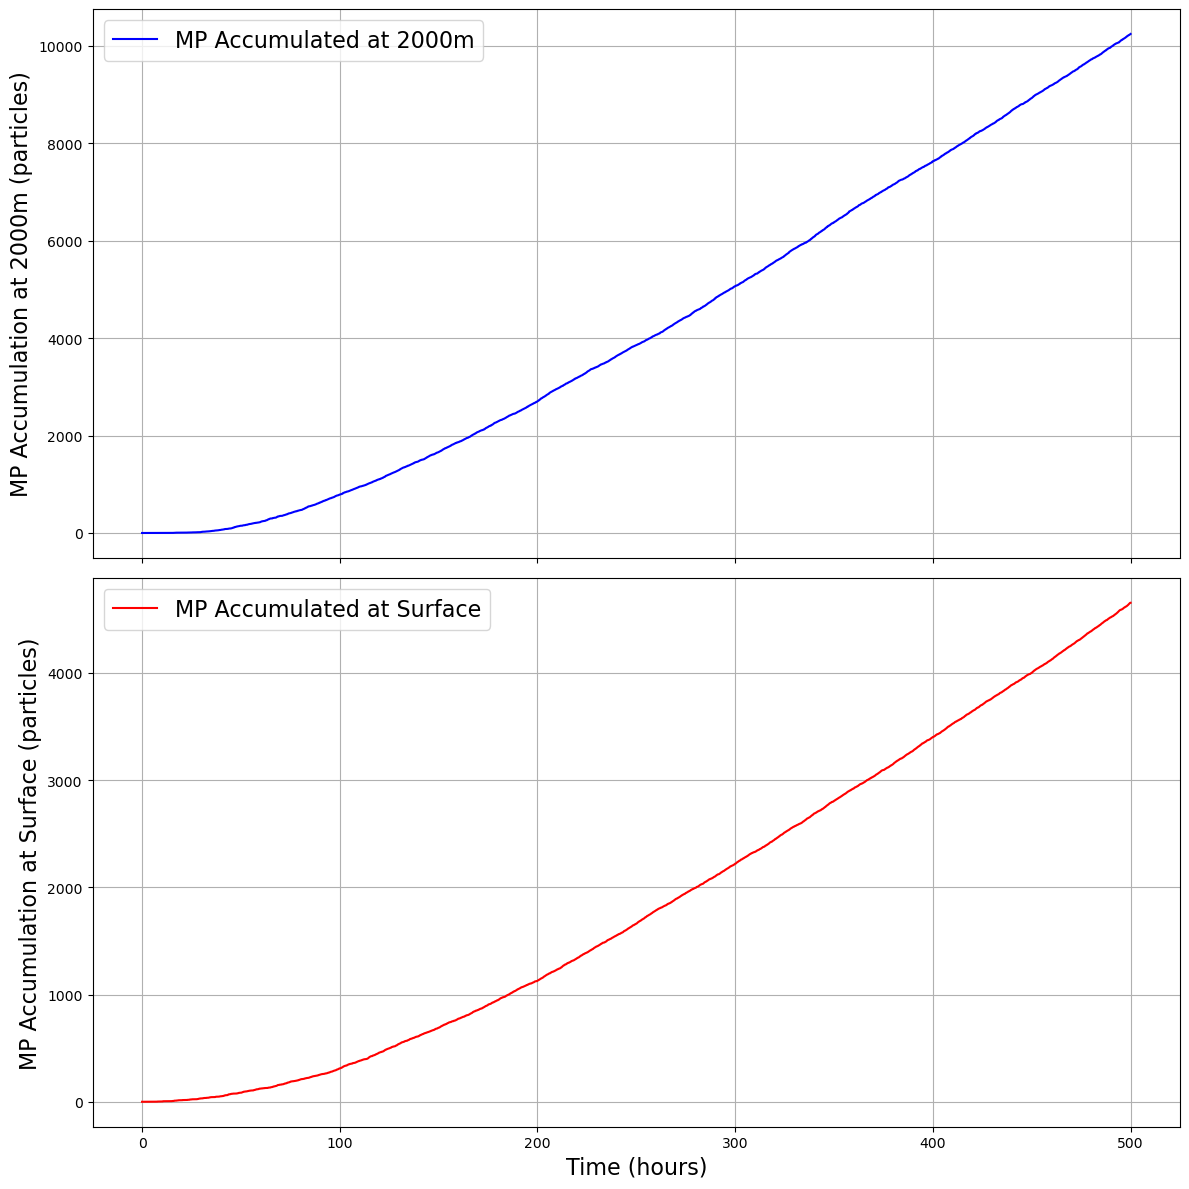

Average gradient of MP Accumulated at 2000m between 300 and 500 hours: 25.894910249999974
Average gradient of MP Accumulated at Surface between 300 and 500 hours: 12.171282750000014
[24.5 27.5 45.5 33.5 29.5 18.5 21.5 44.5 39.5 14.5 39.5 40.5 49.5 52.5
 44.5 45.5 37.5 34.5 41.5 28.5 19.5 43.5 41.5 41.5 13.5 16.5 38.5 39.5
 44.5 34.5 39.5 37.5 23.5 13.5 32.5 39.5 17.5 23.5 31.5 38.5 14.5 39.5
 15.5 19.5 19.5 18.5 22.5 35.5 38.5 44.5 26.5 44.5 14.5 15.5 24.5 44.5
 16.5 33.5 20.5 41.5 26.5 27.5 29.5 24.5 35.5 39.5 15.5 26.5 32.5 15.5
 30.5 39.5 41.5 11.5 18.5 27.5 22.5 26.5 17.5 27.5 15.5 38.5 36.5 23.5
 39.5 37.5 20.5 12.5 38.5 26.5 20.5 13.5 36.5 53.5 22.5 26.5 25.5 27.5
 27.5 22.5]


In [12]:
import joblib
from joblib import Parallel, delayed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from onekrill_onecolumn import (
    calc_clearance_rate, calc_krill_mp_consumption, calc_mp_fp_production_rate,
    calc_sinking_velocity, calc_rising_velocity, calc_length_decrease,
    generate_random, assign_mp_size, assign_krill_length
)

# Simulation Parameters
depth_limit = 2000  # m
time = np.linspace(0, 500, 10000)  # Simulation time in hours
b = -0.32  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of water
gut_passage_time = 2  # Gut passage time in hours
mp_conc = 1909.65  # Microplastic concentration (particles/m³)
rho_p = 960  # Density of microplastic kg/m3

# Load density data
rho_data_path = 'rho_data.csv'
rho_data = pd.read_csv(rho_data_path)

# Get krill lengths
krill_lengths = assign_krill_length(100)

def simulate_krill(krill_length):
    """Simulates one krill's impact on microplastic flux."""
    
    # Compute ingestion and egestion rates
    clearance_rate = calc_clearance_rate(krill_length)
    krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
    time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

    # Fecal pellet release times
    fp_release_times = np.arange(0, max(time), gut_passage_time)
    mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

    # Initialize accumulation arrays
    mp_accumulation_at_2000m = np.zeros_like(time)
    pellets_reaching_2000m = 0
    rising_mp = []

    # Precompute random variables
    num_pellets = len(fp_release_times)
    L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
    D = generate_random(183, 178, 80, 600, size=num_pellets) * 1e-6
    rho_s = generate_random(1121, 1116, 1038, 1391, size=num_pellets)
    mp_size = assign_mp_size(size=num_pellets)

    break_depths = np.random.uniform(100, 300, size=num_pellets)
    break_chances = np.random.rand(num_pellets) < 0.5

    # Simulate sinking for each fecal pellet
    for i, release_time in enumerate(fp_release_times):
        pellet_time = time[time >= release_time]
        time_since_release = pellet_time - release_time

        current_depth = 100
        ws = calc_sinking_velocity(mu, rho_data['Density'].iloc[0], rho_s[i], L_init[i], D[i])
        dt = (time[1] - time[0])
        reached_2000m = False
        mp_released = False
        broke = False

        for t in time_since_release:
            if current_depth >= depth_limit:
                reached_2000m = True
                pellets_reaching_2000m += 1
                break
            
            # Update density based on depth
            nearest_depth_index = (rho_data['Depth'] - current_depth).abs().idxmin()
            rho_at_depth = rho_data.loc[nearest_depth_index, 'Density'] * 1000

            delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
            L = L_init[i] - delta_L


            # Breakage handling
            if current_depth >= break_depths[i] and break_chances[i] and not broke:
                broke = True  
                L /= 2 # Break length in half
                if mp_size[i] > 0.5 * D[i]:
                    mp_released = True
                    wr = calc_rising_velocity(mp_size[i], rho_p, rho_at_depth, mu) / 24
                    rising_mp.append((current_depth, release_time + t, wr))
                else:
                    mp_released = False
            
            ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
            current_depth += (ws / 24) * dt  # Convert to hourly movement

        if reached_2000m and not mp_released:
            index = (np.abs(time - (release_time + t))).argmin()
            mp_accumulation_at_2000m[index] += 1
    
    return mp_accumulation_at_2000m, rising_mp


# ** Run Parallel Simulations **
results = Parallel(n_jobs=-1)(delayed(simulate_krill)(length) for length in krill_lengths)

# Aggregate results
mp_accumulation_at_2000m = np.zeros_like(time)
rising_mp = []

for acc, rising in results:
    mp_accumulation_at_2000m += acc
    rising_mp.extend(rising)

# Simulate rising microplastics
mp_rising_accumulation = np.zeros_like(time)
counted_indices = set()

for depth, release_time, wr in rising_mp:
    pellet_time = time[time >= release_time]
    time_since_release = pellet_time - release_time

    for t in time_since_release:
        if depth <= 100:
            index = (np.abs(time - (release_time + t))).argmin()
            if index not in counted_indices:
                mp_rising_accumulation[index] += 1
                counted_indices.add(index)
            break
        depth -= wr * (time[1] - time[0])

mp_rising_accumulation = np.cumsum(mp_rising_accumulation)
mp_accumulation_at_2000m = np.cumsum(mp_accumulation_at_2000m)

# Plot Results
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex=True)

axes[0].plot(time, mp_accumulation_at_2000m, color='blue', label="MP Accumulated at 2000m")
axes[0].set_ylabel("MP Accumulation at 2000m (particles)", fontsize=16)
axes[0].grid()
axes[0].legend(fontsize=16)

axes[1].plot(time, mp_rising_accumulation, color='red', label="MP Accumulated at Surface")
axes[1].set_xlabel("Time (hours)", fontsize=16)
axes[1].set_ylabel("MP Accumulation at Surface (particles)", fontsize=16)
axes[1].grid()
axes[1].legend(fontsize=16)

plt.tight_layout()
plt.show()

# Approximate the gradient between 300 and 500 hours
time_range = (time >= 300) & (time <= 500)
time_selected = time[time_range]

# Gradient for MP Accumulated at 2000m
mp_accumulation_gradient_2000m = np.gradient(mp_accumulation_at_2000m[time_range], time_selected)
average_gradient_2000m = np.mean(mp_accumulation_gradient_2000m)

# Gradient for MP Accumulated at Surface
mp_rising_gradient_surface = np.gradient(mp_rising_accumulation[time_range], time_selected)
average_gradient_surface = np.mean(mp_rising_gradient_surface)

print(f"Average gradient of MP Accumulated at 2000m between 300 and 500 hours: {average_gradient_2000m}")
print(f"Average gradient of MP Accumulated at Surface between 300 and 500 hours: {average_gradient_surface}")

print(krill_lengths)

# Map plotting

In [67]:
import pandas as pd
import numpy as np

# Load the data
krillbase = pd.read_csv("krillbase/krillbase_data.csv", encoding="ISO-8859-1")

# Replace non-numeric entries in 'STANDARDISED_KRILL_UNDER_1M2' column with NaN
krillbase['STANDARDISED_KRILL_UNDER_1M2'] = pd.to_numeric(krillbase['STANDARDISED_KRILL_UNDER_1M2'], errors='coerce')

# Drop rows where 'STANDARDISED_KRILL_UNDER_1M2' is NaN
krillbase = krillbase.dropna(subset=['STANDARDISED_KRILL_UNDER_1M2'])

# Round the values to 2 decimal places to reduce uniqueness
krillbase['STANDARDISED_KRILL_UNDER_1M2'] = krillbase['STANDARDISED_KRILL_UNDER_1M2'].round(2)

# Create latitude and longitude bins
latitude_bins = np.arange(-90, 90 + 2, 2)
longitude_bins = np.arange(-180, 180 + 4, 4)

# Create the binning and label each row
krillbase['lat_bins'] = pd.cut(krillbase['LATITUDE'], bins=latitude_bins)
krillbase['long_bins'] = pd.cut(krillbase['LONGITUDE'], bins=longitude_bins)

# Function to calculate the area of a bin (in square km)
def calculate_area(lat_bin, long_bin):
    # Get the bin edges
    lat_min = lat_bin.left
    lat_max = lat_bin.right
    long_min = long_bin.left
    long_max = long_bin.right
    
    # Approximate length of one degree of latitude in km (approximately 111 km)
    lat_length = 111  # km
    
    # Calculate the average latitude to account for the varying size of longitude
    avg_lat = (lat_min + lat_max) / 2
    # Length of one degree of longitude in km at the average latitude
    long_length = 111.32 * np.cos(np.radians(avg_lat))  # km
    
    # Area of the bin: width (longitude) * height (latitude)
    area = lat_length * (lat_max - lat_min) * long_length * (long_max - long_min)
    return area

# Apply the calculate_area function to each row
krillbase['Area_km2'] = krillbase.apply(lambda row: calculate_area(row['lat_bins'], row['long_bins']), axis=1)



#add a column with the average standardised krill under 1m2 in each bin
krillbase['mean_standardised'] = krillbase.groupby(['lat_bins', 'long_bins'])['STANDARDISED_KRILL_UNDER_1M2'].transform('mean')


# Now, create a new DataFrame that only contains the bins and total number of krill for each bin
krill_summary = krillbase.groupby(['lat_bins', 'long_bins'])['mean_standardised'].mean().reset_index()

# Display the summary DataFrame

#drop the rows with nan
krill_summary = krill_summary.dropna()

#reset index
krill_summary.reset_index(drop=True, inplace=True)

print(list(krill_summary.mean_standardised))

[0.0, 0.04285714285714286, 0.0, 0.6085714285714285, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4975, 0.0, 0.17666666666666667, 0.03333333333333333, 8.97, 49.195, 5.895, 1.4333333333333333, 0.0, 0.0, 0.0, 0.28, 0.55, 9.055, 134.95666666666668, 1.0625, 7.52, 20.17142857142857, 16.93153846153846, 3.8770000000000002, 10.266, 2.7600000000000002, 0.0, 0.0, 10.84, 3.376666666666667, 0.8160000000000001, 0.0, 0.0, 0.0, 0.0, 0.18, 3.33, 0.6940000000000001, 0.05, 0.84, 0.0, 0.13333333333333333, 0.0, 0.20777777777777778, 0.0725, 34.391999999999996, 41.7, 37.531052631578945, 76.60809523809523, 22.9434, 7.09, 92.08, 0.515, 0.32, 155.404, 1.65, 6.83, 1.4835483870967743, 9.22392156862745, 28.59, 0.355, 2.385, 6.105, 18.477500000000003, 14.808181818181817, 26.679999999999996, 19.9725, 0.0175, 0.5053333333333333, 1.7725, 0.0, 0.0, 0.0, 0.21, 15.240000000000002, 0.0, 0.0375, 0.0, 0.0, 0.0, 0.095, 0.0, 0.0, 0.0, 0.11285714285714286, 0.07, 0.0, 0.0, 0.0, 0.15, 2.81875, 0.16, 0.18166666666666667, 6.56000000000000

C:\Users\elican27\AppData\Local\Temp\ipykernel_26708\1973391414.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  krillbase['mean_standardised'] = krillbase.groupby(['lat_bins', 'long_bins'])['STANDARDISED_KRILL_UNDER_1M2'].transform('mean')
C:\Users\elican27\AppData\Local\Temp\ipykernel_26708\1973391414.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  krill_summary = krillbase.groupby(['lat_bins', 'long_bins'])['mean_standardised'].mean().reset_index()


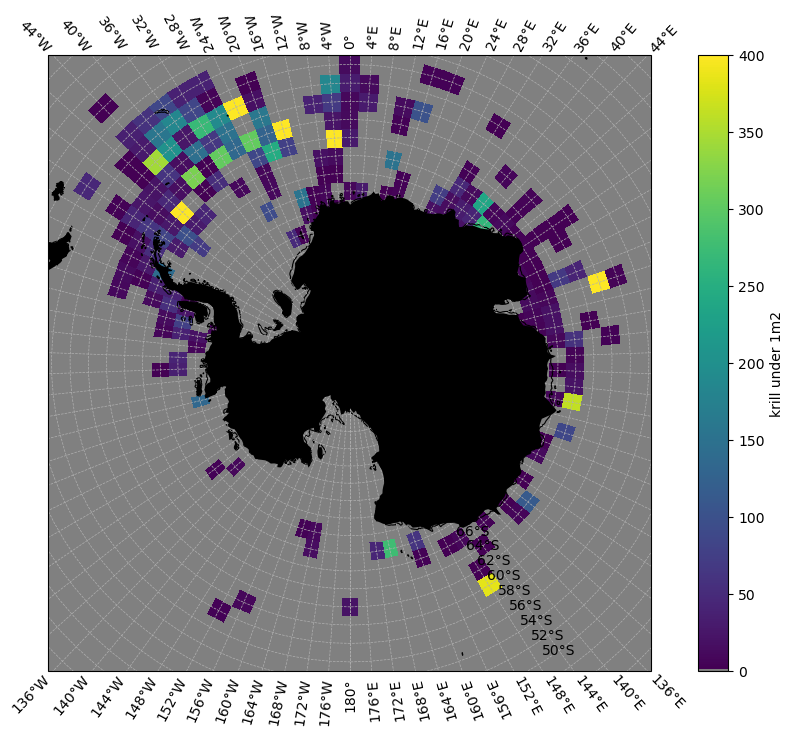

In [71]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import ListedColormap


# Define the projection (South Polar Stereographic)
proj = ccrs.SouthPolarStereo()

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': proj})

# Add land and ocean features
ax.add_feature(cfeature.OCEAN, color='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='black')
ax.add_feature(cfeature.LAND, color='black')

# Set extent (Southern Hemisphere view)
ax.set_extent([-180, 180, -90, -55], crs=ccrs.PlateCarree())

# Add grid lines every 4 degrees
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5)

# Set grid line interval to 4 degrees
gl.xlocator = plt.MultipleLocator(4)  # Longitude grid lines every 4 degrees
gl.ylocator = plt.MultipleLocator(2)  # Latitude grid lines every 4 degrees

krill_grid = np.zeros((len(latitude_bins) - 1, len(longitude_bins) - 1))


#Map the number of krill to the grid (fill in krill_grid based on your bins)
for _, row in krill_summary.iterrows():
    lat_min, lat_max = row['lat_bins'].left, row['lat_bins'].right
    lon_min, lon_max = row['long_bins'].left, row['long_bins'].right
    
    # Find the row and column indices for the grid
    lat_idx = np.digitize([lat_min], latitude_bins) - 1  # Index for latitude
    lon_idx = np.digitize([lon_min], longitude_bins) - 1  # Index for longitude
    
    # Assign the krill value to the corresponding grid cell
    krill_grid[lat_idx, lon_idx] = row['mean_standardised']


# Create a colormap with grey for 0 and the rest for the krill data
# First create the colormap for non-zero values
cmap_viridis = plt.cm.viridis(np.linspace(0, 1, 256))

# Append 'grey' to the beginning of the colormap
cmap = ListedColormap(np.vstack([[0.5, 0.5, 0.5, 1], cmap_viridis]))  # grey RGBA added at the start

# Use pcolormesh to plot the krill data as colored grid squares
# Longitude and latitude bins are used for the grid
mesh = ax.pcolormesh(longitude_bins[:-1], latitude_bins[:-1], krill_grid, cmap=cmap, 
                     transform=ccrs.PlateCarree(), shading='auto', vmin=0, vmax=400)

# Add a colorbar to indicate the number of krill
plt.colorbar(mesh, ax=ax, orientation='vertical', label='krill under 1m2')

# Overlay Antarctica with black (in case any krill grid squares overlap)
ax.add_feature(cfeature.NaturalEarthFeature(
    category='physical', name='land', scale='110m', facecolor='black'), zorder=10)

# Show the plot
plt.show()


# Itertools 

In [ ]:
#count function 

import itertools

counter = itertools.count(start=5, step=5) #counts from 0 up to infinity

print(next(counter)) #prints 0
print(next(counter)) #prints 1
print(next(counter)) #prints 2

data = [100, 200, 300, 400, 500]
#can use count function to provide values for any amount of data
daily_data = zip(itertools.count(), data) #returns an interator that combines the count and data
#can get a list by using list(daily_data)
print(list(daily_data))


#just getting one at a time 






5
10
15
[(0, 100), (1, 200), (2, 300), (3, 400), (4, 500)]


In [7]:
#zip_longest function

import itertools

data = [100, 200, 300, 400, 500]
daily_data = itertools.zip_longest(range(10), data)

print(list(daily_data))
#zip stops when the shortest iterable is exhausted
#zip_longest continues until the longest iterable is exhausted

[(0, 100), (1, 200), (2, 300), (3, 400), (4, 500), (5, None), (6, None), (7, None), (8, None), (9, None)]


In [9]:
#cycle function
#returns an iterable that will go forever
#can be used to cycle through a list

import itertools

counter = itertools.cycle([1, 2, 3])
print(next(counter)) #prints 1
print(next(counter)) #prints 2
print(next(counter)) #prints 3
print(next(counter)) #prints 1
print(next(counter)) #prints 2

1
2
3
1
2


In [ ]:
#repeat function
#returns an iterator that produces the same value each time it is called
#can be used to repeat a value a certain number of times
import itertools

counter = itertools.repeat(2, times=3)

squares = map(pow, range(10), itertools.repeat(2)) #map takes a functino and then it takes iterables and applies the function to each element of the iterable
print(list(squares)) 


# print(next(counter)) #prints 2
# print(next(counter)) #prints 2
# print(next(counter)) #prints 2
# print(next(counter)) #prints 2 #get an error here becuase it has been repeated 3 times
# print(next(counter)) #prints 2

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [4]:
#starmap function
#similar to map but the function takes arguments as a tuple
import itertools

squares = itertools.starmap(pow, [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)])
print(list(squares)) #prints [0, 1, 4, 9, 16]

[0, 1, 4, 9, 16]


In [5]:
#chain function

import itertools

letters = ['a', 'b', 'c', 'd']
numbers = [1, 2, 3, 4]
names = ['Corey', 'Nicole'] 

combined = itertools.chain(letters, numbers, names)

for item in combined:
    print(item)


a
b
c
d
1
2
3
4
Corey
Nicole


In [6]:
#islice function
#similar to slicing a list
import itertools

result = itertools.islice(range(10), 1, 5, 2) #start at 1, stop at 5, step by 2
for item in result:
    print(item)

1
3


# Tracking single FP

In [ ]:
##This does not have the most recent updates - breakage and MP size ones 16/2 and 17/2 updates from notion

import numpy as np
import matplotlib.pyplot as plt
from onekrill_onecolumn import (
    calc_clearance_rate,
    calc_krill_mp_consumption,
    calc_mp_fp_production_rate,
    calc_sinking_velocity,
    calc_fp_width_um,
    calc_length_decrease,
    generate_random,
    swdens
)
import scipy.stats as stats
import netCDF4 as nc
import pandas as pd

# Parameters
krill_length_mm = 50  # mm
mp_conc = 500  # particles/m3
depth_limit = 2000  # m
time = np.linspace(0, 200, 1000)  # Simulation time in hours
b = -0.3  # Attenuation coefficient
mu = 0.001  # Viscosity of water
rho = 1025  # Density of seawater 
gut_passage_time = 2  # Gut passage time in hours

##importing the temperature and salinity 
temp_data = nc.Dataset('C:/Users/elican27/Documents/Antarctic_krill/Model/Ocean_data/cmems_mod_glo_phy-thetao_anfc_0.083deg_P1M-m_1739443916403.nc')
sal_data = nc.Dataset('C:/Users/elican27/Documents/Antarctic_krill/Model/Ocean_data/cmems_mod_glo_phy-so_anfc_0.083deg_P1M-m_1739443856060.nc')
# Get the temperature variable (adjust the name if different in your file)
temp = temp_data.variables['thetao'][:]  # This will return a numpy array
# Get the depth dimension (adjust the name if necessary)
depth_t = temp_data.variables['depth'][:]  # Depth values as a numpy array
# Get the time dimension (if relevant)
time_t = temp_data.variables['time'][:]  # Time values as a numpy array (months or days, etc.)
# Get the latitude and longitude (if available, adjust names if necessary)
lat_t = temp_data.variables['latitude'][:]  # Latitude values as a numpy array
lon_t = temp_data.variables['longitude'][:]  # Longitude values as a numpy array
# Average over time, latitude, and longitude dimensions (axis 0, 2, and 3)
avg_temp = np.mean(temp, axis=(0, 2, 3))
temp_avg = pd.DataFrame({
    'Depth': depth_t,
    'Average Temperature': avg_temp})
temp_avg = temp_avg.dropna()


# Get the temperature variable (adjust the name if different in your file)
sal = sal_data.variables['so'][:]  # This will return a numpy array
# Get the depth dimension (adjust the name if necessary)
depth_s = sal_data.variables['depth'][:]  # Depth values as a numpy array
# Get the time dimension (if relevant)
time_s = sal_data.variables['time'][:]  # Time values as a numpy array (months or days, etc.)
# Get the latitude and longitude (if available, adjust names if necessary)
lat_s = sal_data.variables['latitude'][:]  # Latitude values as a numpy array
lon_s = sal_data.variables['longitude'][:]  # Longitude values as a numpy array
# Average over time, latitude, and longitude dimensions (axis 0, 2, and 3)
avg_sal = np.mean(sal, axis=(0, 2, 3))
sal_avg = pd.DataFrame({
    'Depth': depth_s,
    'Average Salinity': avg_sal})
sal_avg = sal_avg.dropna()


##merge the two data sets on the depth column 
temp_sal_data = pd.merge(temp_avg, sal_avg, how = 'inner')
temp_sal_data['Density'] = swdens(temp_sal_data['Average Temperature'], temp_sal_data['Average Salinity'])


# Compute ingestion and egestion rates
clearance_rate = calc_clearance_rate(krill_length_mm)
krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

# Fecal pellet release times
fp_release_times = np.arange(0, max(time), gut_passage_time)
mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)



# Create figure
fig, ax = plt.subplots(figsize=(12, 10))

# Simulate sinking for each fecal pellet
for release_time in fp_release_times:
    pellet_time = time[time >= release_time]  # Time after release
    time_since_release = pellet_time - release_time  # Time elapsed since egestion

    # **Generate unique length, width, and density for each fecal pellet**
    L_init = generate_random(2927, 2667, 517, 34482) * 10**-6  # Initial FP length (m)
    D = generate_random(183, 178, 80, 600) * 10**-6  # Width/diameter of FP (m)
    rho_s = generate_random(1121, 1116, 1038, 1391)  # Density of krill FP

    # Compute initial sinking velocity for this pellet
    initial_sinking_velocity = calc_sinking_velocity(mu, rho, rho_s, L_init, D)

    # Initialize values
    current_depth = 100
    L = L_init
    ws = initial_sinking_velocity
    dt = (time[1] - time[0])  # Time step in hours
    sinking_depths = []
    
    # Store breakage points for visualization
    breakage_points = []  # List to store (time, depth) of breakage events

    # # Determine if this FP will break within the top 300m
    # will_break = np.random.rand() < 0.2  # 20% probability
    broke = False  # Track if breakage occurred

    for t in time_since_release:
        if current_depth >= depth_limit:
            break  # Stop tracking if pellet reaches the max depth
            
        # Update length based on depth
        delta_L = L_init - calc_length_decrease(L_init, b, current_depth)

        
            # Apply breakage if within top 300m
        if 110 <= current_depth <= 300 and np.random.rand() < 0.02 and not broke:
            #print(f"Before break: Length = {L:.6f}, Sinking velocity = {ws:.6f}")
            L = (L_init - delta_L) / 2  # Halve the length upon breakage
            broke = True 
            breakage_points.append((release_time + t, current_depth))
            #ws = calc_sinking_velocity(mu, rho_at_depth, rho_s, L, D)  # Recalculate ws
            #print(f"After break: Length = {L:.6f}, Sinking velocity = {ws:.6f}")

        else:
            L = L_init - delta_L
        
        #update the water density
        nearest_depth_index = (temp_sal_data['Depth'] - current_depth).abs().idxmin()
        rho_at_depth = temp_sal_data.loc[nearest_depth_index, 'Density'] *1000

        # Recalculate sinking velocity with updated length
        ws = calc_sinking_velocity(mu, rho_at_depth, rho_s, L, D) 
        ws_per_hour = ws / 24  # Convert m/day to m/hour
        
        # Update depth
        current_depth += ws_per_hour * dt
        sinking_depths.append(current_depth)
        
        # Plot breakage points
    if breakage_points:
        break_times, break_depths = zip(*breakage_points)  # Extract times and depths
        ax.scatter(break_times, break_depths, color='black', marker='x', label="Breakage Event", s=50)

    # Stop at max depth
    sinking_depths = np.clip(sinking_depths, 0, depth_limit)

    # Determine if this FP contains microplastics
    contains_mp = np.any(np.isclose(release_time, mp_fp_release_times, atol=gut_passage_time / 2))
    color = "red" if contains_mp else "blue"

    ax.plot(pellet_time[:len(sinking_depths)], sinking_depths, color=color)

# Formatting
ax.invert_yaxis()  # Invert y-axis to show depth increasing downward
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Depth (m)")
#ax.set_title(f"Sinking Fecal Pellets with Stopping Condition at 40% Mass Loss")
ax.grid()

# Add legend
ax.plot([], [], color='red', label='Contains Microplastics')
ax.plot([], [], color='blue', label='No Microplastics')
#ax.legend()

# Show plot
plt.show()

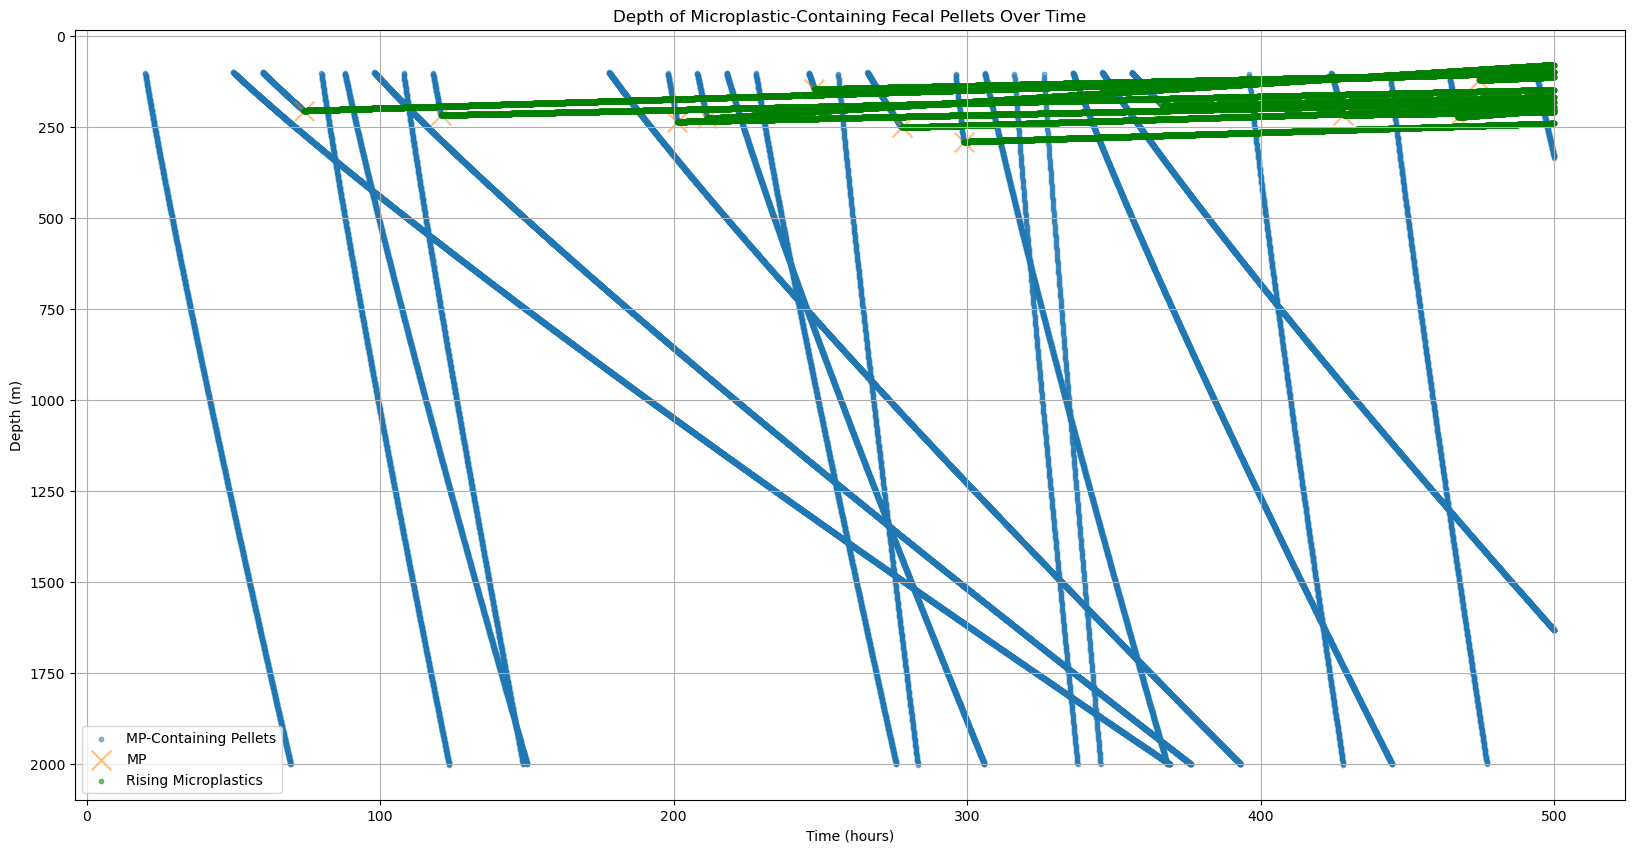

In [2]:
#%% microplastics rising again

import numpy as np
import matplotlib.pyplot as plt
from onekrill_onecolumn import (
    calc_clearance_rate,
    calc_krill_mp_consumption,
    calc_mp_fp_production_rate,
    calc_sinking_velocity,
    calc_length_decrease,
    generate_random,
    calc_rising_velocity,
    assign_mp_size
)
import pandas as pd
from scipy.interpolate import interp1d

# Parameters (unchanged)
krill_length_mm = 50
depth_limit = 2000
time = np.linspace(0, 500, 10000)
b = -0.32
mu = 0.001
rho = 1025
gut_passage_time = 2
mass_loss_threshold = 0.4
mp_conc = 1909.65
rho_p = 960
mp_release_depths = []
mp_release_events = []

# Compute ingestion/egestion rates (unchanged)
clearance_rate = calc_clearance_rate(krill_length_mm)
krill_mp_consumption = calc_krill_mp_consumption(clearance_rate, mp_conc)
time_produce_one_mp_fp = calc_mp_fp_production_rate(krill_mp_consumption, gut_passage_time)

# Fecal pellet release times (unchanged)
fp_release_times = np.arange(0, max(time), gut_passage_time)
mp_fp_release_times = np.arange(time_produce_one_mp_fp, max(time), time_produce_one_mp_fp)

# Load density data and interpolate (unchanged)
rho_data = pd.read_csv('C:/Users/elican27/Documents/Antarctic_krill/Model/rho_data.csv')
rho_interp = interp1d(rho_data['Depth'], rho_data['Density'] * 1000, kind='linear', fill_value="extrapolate")

# Precompute pellet properties (unchanged)
num_pellets = len(fp_release_times)
L_init = generate_random(2927, 2667, 517, 34482, size=num_pellets) * 1e-6
D = generate_random(183, 178, 80, 600, size=num_pellets) * 1e-6
rho_s = generate_random(1121, 1116, 1038, 1391, size=num_pellets)
mp_size = assign_mp_size(size=num_pellets)
break_depths = np.random.uniform(100, 300, size=num_pellets)
break_chances = np.random.rand(num_pellets) < 0.5

# Identify MP-containing pellets
tolerance = gut_passage_time / 2
is_mp_pellet = np.zeros(num_pellets, dtype=bool)


for i in range(num_pellets):
    # Check if release time matches MP pellet release times
    time_match = np.any(np.isclose(fp_release_times[i], mp_fp_release_times, atol=tolerance))
    # Check if MP size is smaller than pellet diameter
    size_condition = (mp_size[i] < D[i])
    is_mp_pellet[i] = time_match and size_condition

# Initialize storage for depth-time data
mp_depth_over_time = []

# Simulate sinking for MP-containing pellets
for i in np.where(is_mp_pellet)[0]:
    release_time = fp_release_times[i]
    pellet_time = time[time >= release_time]
    time_since_release = pellet_time - release_time
    
    current_depth = 100
    ws = calc_sinking_velocity(mu, rho_interp(current_depth), rho_s[i], L_init[i], D[i])
    dt = time[1] - time[0]
    broke = False
    mp_released = False
    
    for t in time_since_release:
        if current_depth >= depth_limit or mp_released:
            break  # Stop if sunk or MP released
        
        # Update length based on depth
        delta_L = L_init[i] - calc_length_decrease(L_init[i], b, current_depth)
        
        global_time = release_time + t
        
        # Apply breakage if within top 300m
        if current_depth >= break_depths[i] and break_chances[i] and not broke:
            broke = True
            if mp_size[i] > 0.5 * D[i]:
                mp_released = True  # MP released, stop tracking
                global_time = release_time + t
                mp_release_events.append((global_time, current_depth, mp_size[i]))
                break
        
        # Calculate density and sinking velocity
        rho_at_depth = rho_interp(current_depth)
        L = L_init[i] - delta_L if not broke else (L_init[i] - delta_L) / 2
        ws = calc_sinking_velocity(mu, rho_at_depth, rho_s[i], L, D[i])
        ws_per_hour = ws / 24
        current_depth += ws_per_hour * dt
        
        # Record depth and time
    
        mp_depth_over_time.append((global_time, current_depth))
        

mp_rising_trajectories = []

for event in mp_release_events:
    release_time, release_depth, size = event
    velocity = calc_rising_velocity(size, rho_p, rho, mu)  # m/day
    velocity_hour = velocity / 24  # Convert to m/hour
    
    # Get times after release
    post_release_times = time[time >= release_time]
    
    for t in post_release_times:
        elapsed_hours = t - release_time
        new_depth = release_depth - velocity_hour * elapsed_hours
        if new_depth <= 0:
            new_depth = 0
            break  # Stop tracking after surfacing
        mp_rising_trajectories.append((t, new_depth))

# Convert to DataFrame for analysis
import pandas as pd
df_fp = pd.DataFrame(mp_depth_over_time, columns=['Time (hours)', 'Depth (m)'])
df_mp = pd.DataFrame(mp_release_events, columns=['Time (hours)', 'Depth (m)', 'Size (um)'])
df_rising = pd.DataFrame(mp_rising_trajectories, columns=['Time (hours)', 'Depth (m)'])

# Plot results
plt.figure(figsize=(20, 10))
plt.scatter(df_fp['Time (hours)'], df_fp['Depth (m)'], alpha=0.5, s=10, label='MP-Containing Pellets')
plt.scatter(df_mp['Time (hours)'], df_mp['Depth (m)'], alpha=0.5, s=200, label='MP', marker = 'x')
plt.scatter(df_rising['Time (hours)'], df_rising['Depth (m)'], 
           alpha=0.5, s=10, color='green', label='Rising Microplastics')
plt.gca().invert_yaxis()  # Depth increases downward
plt.xlabel('Time (hours)')
plt.ylabel('Depth (m)')
plt.title('Depth of Microplastic-Containing Fecal Pellets Over Time')
plt.grid()
plt.legend()
plt.show()

# Data analysis

## Density data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from onekrill_onecolumn import (
    calc_clearance_rate,
    calc_krill_mp_consumption,
    calc_mp_fp_production_rate,
    calc_sinking_velocity,
    calc_fp_width_um,
    calc_length_decrease,
    generate_random,
    swdens,
    assign_mp_size
)
import netCDF4 as nc
import pandas as pd

##importing the temperature and salinity 
temp_data = nc.Dataset('C:/Users/elican27/Documents/Antarctic_krill/Model/Ocean_data/cmems_mod_glo_phy-thetao_anfc_0.083deg_P1M-m_1739443916403.nc')
sal_data = nc.Dataset('C:/Users/elican27/Documents/Antarctic_krill/Model/Ocean_data/cmems_mod_glo_phy-so_anfc_0.083deg_P1M-m_1739443856060.nc')
# Get the temperature variable (adjust the name if different in your file)
temp = temp_data.variables['thetao'][:]  # This will return a numpy array
# Get the depth dimension (adjust the name if necessary)
depth_t = temp_data.variables['depth'][:]  # Depth values as a numpy array
# Get the time dimension (if relevant)
time_t = temp_data.variables['time'][:]  # Time values as a numpy array (months or days, etc.)
# Get the latitude and longitude (if available, adjust names if necessary)
lat_t = temp_data.variables['latitude'][:]  # Latitude values as a numpy array
lon_t = temp_data.variables['longitude'][:]  # Longitude values as a numpy array
# Average over time, latitude, and longitude dimensions (axis 0, 2, and 3)
avg_temp = np.mean(temp, axis=(0, 2, 3))
temp_avg = pd.DataFrame({
    'Depth': depth_t,
    'Average Temperature': avg_temp})
temp_avg = temp_avg.dropna()


# Get the temperature variable (adjust the name if different in your file)
sal = sal_data.variables['so'][:]  # This will return a numpy array
# Get the depth dimension (adjust the name if necessary)
depth_s = sal_data.variables['depth'][:]  # Depth values as a numpy array
# Get the time dimension (if relevant)
time_s = sal_data.variables['time'][:]  # Time values as a numpy array (months or days, etc.)
# Get the latitude and longitude (if available, adjust names if necessary)
lat_s = sal_data.variables['latitude'][:]  # Latitude values as a numpy array
lon_s = sal_data.variables['longitude'][:]  # Longitude values as a numpy array
# Average over time, latitude, and longitude dimensions (axis 0, 2, and 3)
avg_sal = np.mean(sal, axis=(0, 2, 3))
sal_avg = pd.DataFrame({
    'Depth': depth_s,
    'Average Salinity': avg_sal})
sal_avg = sal_avg.dropna()


##merge the two data sets on the depth column 
temp_sal_data = pd.merge(temp_avg, sal_avg, how = 'inner')
temp_sal_data['Density'] = swdens(temp_sal_data['Average Temperature'], temp_sal_data['Average Salinity'])
rho_data = temp_sal_data

# Save density dataset separately
rho_data_path = 'C:/Users/elican27/Documents/Antarctic_krill/Model/rho_data.csv'
rho_data.to_csv(rho_data_path, index=False)

## FP lengths

In [ ]:
#%% analysing the FP_length data 

import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stats
import numpy as np

FP_length = pd.read_csv('FP_length.csv')

def truncated_normal_pdf(mean, min_val, max_val, num_points=1000):
    """
    Computes x-values and corresponding PDF values for a truncated normal distribution.

    Parameters:
        mean (float): Mean of the distribution.
        min_val (float): Minimum possible value.
        max_val (float): Maximum possible value.
        num_points (int): Number of points for smooth curve.

    Returns:
        x (numpy array): Range of values from min_val to max_val.
        pdf_y (numpy array): PDF values corresponding to x.
    """
    # Estimate standard deviation
    std_dev = (max_val - min_val) / 6  # Rough estimate assuming normal-like distribution

    # Define bounds in standard normal form
    lower_bound = (min_val - mean) / std_dev
    upper_bound = (max_val - mean) / std_dev

    # Create truncated normal distribution
    distribution = stats.truncnorm(lower_bound, upper_bound, loc=mean, scale=std_dev)

    # Generate x values (range for PDF calculation)
    x = np.linspace(min_val, max_val, num_points)

    # Compute the probability density function (PDF)
    pdf_y = distribution.pdf(x)

    return x, pdf_y  # Return values for plotting

x, pdf_y = truncated_normal_pdf(2.927, 0.517, 4.0, num_points=1000)
pdf_y_scaled = pdf_y * 16 / max(pdf_y)  # Normalize PDF to histogram

x_remin = calc_length_decrease(x, -0.32, 300)
mean_remin = calc_length_decrease(2.927, -0.3, 300)

mean_length = FP_length['Length '].mean()

plt.hist(FP_length['Length '], bins = 40, label='300m data')
plt.plot(x, pdf_y_scaled, color='red', linewidth=2, label="Atkinson et al 2012 data")
plt.plot(x_remin, pdf_y_scaled, color = 'orange', linewidth=2, label= "Length after remineralisation")
plt.axvline(x=mean_remin, color='orange', linestyle='--', linewidth=2, label = "Mean at 300m (remineralization)")
plt.axvline(x=mean_length, color='blue', linestyle='--', linewidth=2, label="Mean at 300m")
plt.axvline(x=2.927, color='red', linestyle='--', linewidth=2, label="Mean at surface")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))


plt.show()

#proportion of FP below 0.5mm 
below_count = (FP_length['Length '] < 0.5).sum()
above_count = (FP_length['Length ']  > 0.5).sum()

# Calculate the ratio
ratio = below_count / above_count if above_count > 0 else float('inf')

# Print the result
print(f"Ratio of values below 0.5 to above 0.5: {ratio}") 

## Microplastic data

In [ ]:
#%% Analysing the microplastics data 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#importing the size and concentration data set and merge them on lat or long?
dimension_data_PE = pd.read_excel("C:/Users/elican27/Documents/Antarctic_krill/Model/BODC-JC16001_Plastic_horizontal_dimensions_v17072020.xlsx", sheet_name="Particle dimensions-PE")
dimension_data_PP = pd.read_excel("C:/Users/elican27/Documents/Antarctic_krill/Model/BODC-JC16001_Plastic_horizontal_dimensions_v17072020.xlsx", sheet_name="Particle dimensions-PP")
dimension_data_PS = pd.read_excel("C:/Users/elican27/Documents/Antarctic_krill/Model/BODC-JC16001_Plastic_horizontal_dimensions_v17072020.xlsx", sheet_name="Particle dimensions-PS")
conc_data = pd.read_excel("C:/Users/elican27/Documents/Antarctic_krill/Model/BODC-JC16001_Plastic_counts-v17072020.xlsx")

columns_to_fill_dimension_PE = ['Cruise ', 'Sampling date [dd-mm-yyyy]', 'Sampling Time [hh:mm:ss]',
       'Sampling position_Latitude [degrees_north]',
       'Sampling position_Longitude [degrees_east]', 'Science event',
       'SAPS deployment ID', 'Sampling Depth [m]']
columns_to_fill_dimension_PP = ['Cruise ', 'Sampling date [dd-mm-yyyy]', 'Sampling Time [hh:mm:ss]',
       'Sampling position_Latitude [degrees_north]',
       'Sampling position_Longitude [degrees_east]', 'Science event',
       'SAPS deployment ID', 'Sampling Depth [m]']
columns_to_fill_dimension_PS = ['Cruise ', 'Sampling date [dd-mm-yyyy]', 'Sampling Time [hh:mm:ss]',
       'Sampling position_Latitude [degrees_north]',
       'Sampling position_Longitude [degrees_east]', 'Science event',
       'SAPS deployment ID', 'Sampling Depth [m]']
columns_to_fill_conc = ['Cruise', 'Sampling Date [dd/mm/yyyy]', 'Sampling Time [hh:mm:ss]',
       'Latitude [degrees_north]', 'Longitude [degrees_east]', 'Science event',
       'SAPS deployment ID', 'Sample ID ', 'Depth (m)', 'Volume sampled (L)']

dimension_data_PE[columns_to_fill_dimension_PE] = dimension_data_PE[columns_to_fill_dimension_PE].fillna(method="ffill")
dimension_data_PP[columns_to_fill_dimension_PP] = dimension_data_PP[columns_to_fill_dimension_PP].fillna(method="ffill")
dimension_data_PS[columns_to_fill_dimension_PS] = dimension_data_PE[columns_to_fill_dimension_PS].fillna(method="ffill")
conc_data[columns_to_fill_conc] = conc_data[columns_to_fill_conc].fillna(method="ffill")

conc_data['Depth (m)'] = conc_data['Depth (m)'].astype(int)

conc_data_so = conc_data[(conc_data['Latitude [degrees_north]'] <-40) &(conc_data['Depth (m)'] == 10)]
#print(conc_data_so.columns)


#Working out the average microplastic concentration 
conc_data_so['Total_MP'] = conc_data_so['Number of particles - Polyethylene (N)']  + conc_data_so['Number of particles - Polypropylene (N)'] + conc_data_so['Number of particles - Polystyrene (N)']
conc_data_so['Conc (particles/m3)'] = (conc_data_so['Total_MP']/ conc_data_so['Volume analysed (L)']) * 1000

#print(conc_data_so['Conc (particles/m3)'])

avg_conc = conc_data_so['Conc (particles/m3)'].mean()

#print(avg_conc)

#size distribution for all of the different plastic types - do I just clump then together?

dimension_data_PE['Sampling Depth [m]'] = dimension_data_PE['Sampling Depth [m]'].astype(int)
dimension_data_PP['Sampling Depth [m]'] = dimension_data_PP['Sampling Depth [m]'].astype(int)
dimension_data_PS['Sampling Depth [m]'] = dimension_data_PS['Sampling Depth [m]'].astype(int)

dimension_data_PS['Sampling position_Latitude [degrees_north]'] = pd.to_numeric(
    dimension_data_PS['Sampling position_Latitude [degrees_north]'], errors='coerce')
dimension_data_PS['Sampling Depth [m]'] = pd.to_numeric(
    dimension_data_PS['Sampling Depth [m]'], errors='coerce')

dimension_data_PE_so = dimension_data_PE[(dimension_data_PE['Sampling position_Latitude [degrees_north]'] < -40) &(dimension_data_PE['Sampling Depth [m]'] == 10)]
dimension_data_PP_so = dimension_data_PP[(dimension_data_PP['Sampling position_Latitude [degrees_north]'] < -40) &(dimension_data_PP['Sampling Depth [m]'] == 10)]
#dimension_data_PS_so = dimension_data_PS[(dimension_data_PS['Sampling position_Latitude [degrees_north]'] < -40) &(dimension_data_PS['Sampling Depth [m]'] == 10)]
#There is no PS data from around South Georgia!!!

dimension_data_so = pd.concat([dimension_data_PE_so, dimension_data_PP_so], ignore_index=True)
#print(dimension_data_so.columns)


sns.kdeplot(data = dimension_data_so, x='Feret diameter [µm]',hue = 'Polymer' ,fill=True, common_norm=False, palette='coolwarm')
##There is only one PP data point in the around South Georgia in the mixed layer 
#Thats why the plot only looks like it has one polymer type 
plt.show()

print(dimension_data_so['Feret diameter [µm]'].min())


In [ ]:
# frequnecy distribution from Nan's data

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
feret_diameters = [
    40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 250, 260, 270,
    280, 290, 300, 320, 340, 360, 380, 400, 450, 500
]

normalized_frequencies = np.array([
    0.00243309, 0.00851582, 0.02433090, 0.04257908, 0.06690998,
    0.09732360, 0.09489051, 0.09124088, 0.08515815, 0.07907543,
    0.07055961, 0.03649635, 0.03892944, 0.04257908, 0.04501217,
    0.04014599, 0.03406326, 0.03041363, 0.02433090, 0.01824818,
    0.01216545, 0.00729927, 0.00486618, 0.00243309
])

# Normalize frequencies (just in case)
normalized_frequencies /= normalized_frequencies.sum()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=feret_diameters, y=normalized_frequencies, color='royalblue', edgecolor='black')

# Labels and title
plt.xlabel("Feret Diameter (µm)")
plt.ylabel("Normalized Frequency")
plt.title("Frequency Distribution of Feret Diameters")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

plt.show()

## Krill lengths and numbers

58
58


<Axes: xlabel='length', ylabel='frequency'>

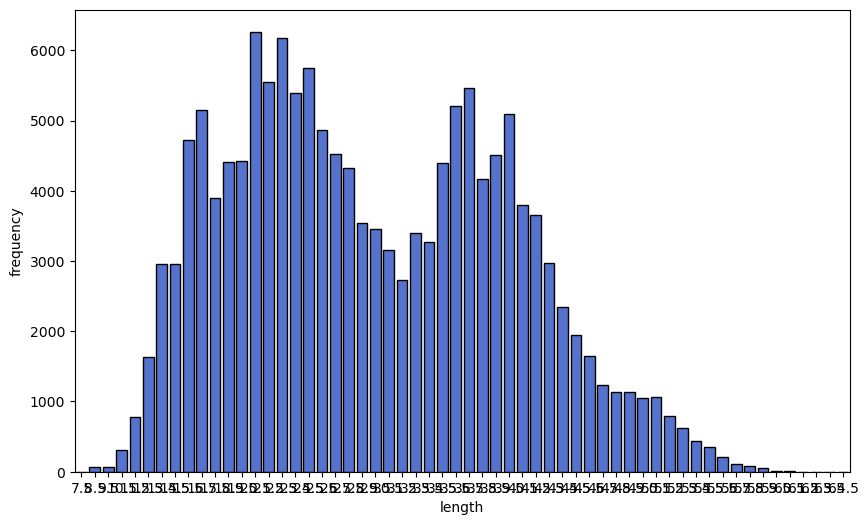

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#krill length data (excel file)
krill_length = pd.read_csv("krill_length_data_datazoo.csv")

frequencies = krill_length.iloc[-1,8:-1].values

#convert to numbers from floats
frequencies = pd.to_numeric(frequencies)


lengths = np.arange(7.5, 65, 1)

print(len(lengths))
print(len(frequencies))

krill_length_clean = pd.DataFrame({
    'length': lengths,
    'frequency': frequencies
})

#save the data to a csv file
#krill_length_clean.to_csv("krill_length_clean.csv", index=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=krill_length_clean, x='length', y='frequency', color='royalblue', edgecolor='black')




In [44]:
import pandas as pd
import numpy as np

# Load the data
krillbase = pd.read_csv("krillbase/krillbase_data.csv", encoding="ISO-8859-1")

# Replace non-numeric entries in 'STANDARDISED_KRILL_UNDER_1M2' column with NaN
krillbase['STANDARDISED_KRILL_UNDER_1M2'] = pd.to_numeric(krillbase['STANDARDISED_KRILL_UNDER_1M2'], errors='coerce')

# Drop rows where 'STANDARDISED_KRILL_UNDER_1M2' is NaN
krillbase = krillbase.dropna(subset=['STANDARDISED_KRILL_UNDER_1M2'])

# Round the values to 2 decimal places to reduce uniqueness
krillbase['STANDARDISED_KRILL_UNDER_1M2'] = krillbase['STANDARDISED_KRILL_UNDER_1M2'].round(2)

# Create latitude and longitude bins
latitude_bins = np.arange(-90, 90 + 4, 4)
longitude_bins = np.arange(-180, 180 + 8, 8)

# Create the binning and label each row
krillbase['lat_bins'] = pd.cut(krillbase['LATITUDE'], bins=latitude_bins)
krillbase['long_bins'] = pd.cut(krillbase['LONGITUDE'], bins=longitude_bins)

# Function to calculate the area of a bin (in square km)
def calculate_area(lat_bin, long_bin):
    # Get the bin edges
    lat_min = lat_bin.left
    lat_max = lat_bin.right
    long_min = long_bin.left
    long_max = long_bin.right
    
    # Approximate length of one degree of latitude in km (approximately 111 km)
    lat_length = 111  # km
    
    # Calculate the average latitude to account for the varying size of longitude
    avg_lat = (lat_min + lat_max) / 2
    # Length of one degree of longitude in km at the average latitude
    long_length = 111.32 * np.cos(np.radians(avg_lat))  # km
    
    # Area of the bin: width (longitude) * height (latitude)
    area = lat_length * (lat_max - lat_min) * long_length * (long_max - long_min)
    return area

# Apply the calculate_area function to each row
krillbase['Area_km2'] = krillbase.apply(lambda row: calculate_area(row['lat_bins'], row['long_bins']), axis=1)



#add a column with the average standardised krill under 1m2 in each bin
krillbase['mean_standardised'] = krillbase.groupby(['lat_bins', 'long_bins'])['STANDARDISED_KRILL_UNDER_1M2'].transform('mean')

# Check the first few rows to verify

krillbase['no_krill'] = krillbase['Area_km2'] * krillbase['mean_standardised']


# Now, create a new DataFrame that only contains the bins and total number of krill for each bin
krill_summary = krillbase.groupby(['lat_bins', 'long_bins'])['no_krill'].sum().reset_index()

# Display the summary DataFrame

#drop the rows with zero krill 
krill_summary = krill_summary[krill_summary['no_krill'] != 0]

#reset index
krill_summary.reset_index(drop=True, inplace=True)

krill_summary

C:\Users\elican27\AppData\Local\Temp\ipykernel_26708\1572502837.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  krillbase['mean_standardised'] = krillbase.groupby(['lat_bins', 'long_bins'])['STANDARDISED_KRILL_UNDER_1M2'].transform('mean')
C:\Users\elican27\AppData\Local\Temp\ipykernel_26708\1572502837.py:58: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  krill_summary = krillbase.groupby(['lat_bins', 'long_bins'])['no_krill'].sum().reset_index()


,lat_bins,long_bins,no_krill
0,"(-78, -74]","(-52, -44]",8.609221e+04
1,"(-78, -74]","(-44, -36]",4.075031e+05
2,"(-78, -74]","(-28, -20]",1.903594e+05
3,"(-74, -70]","(-172, -164]",6.475963e+04
4,"(-74, -70]","(-148, -140]",3.372389e+05
...,...,...,...
128,"(-54, -50]","(-28, -20]",3.659845e+07
129,"(-54, -50]","(-4, 4]",3.410321e+07
130,"(-54, -50]","(4, 12]",2.434379e+05
131,"(-54, -50]","(12, 20]",6.085947e+04
